In [2]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import style
import pandas as pd
import numpy as np

# Paper specific settings
STANDARD_WIDTH = 17.8
SINGLE_COL_WIDTH = STANDARD_WIDTH / 2
DOUBLE_COL_WIDTH = STANDARD_WIDTH
def cm_to_inch(value):
    return value/2.54
    
# matplotlib style settings
matplotlib.rcParams['text.usetex'] = False
style.use('seaborn-white')
plt.rcParams["axes.grid"] = True
plt.rcParams["axes.grid.axis"] = "both"
plt.rcParams["grid.linewidth"] = 0.8
plt.rcParams["font.family"] = "Nimbus Roman"
pd.options.display.max_columns = None
pd.options.display.max_rows = None

'NimbusRoman-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


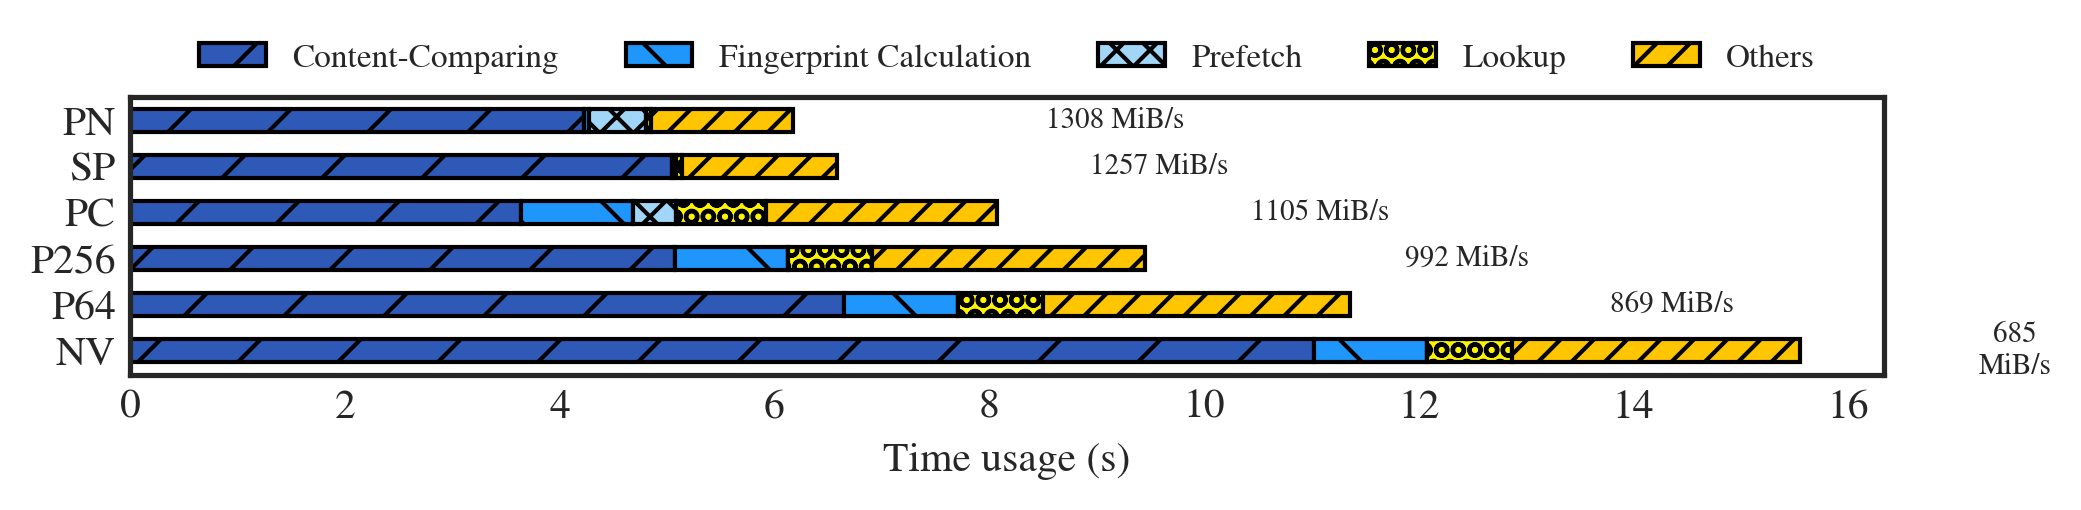

In [8]:
matplotlib.rcParams['text.usetex'] = False
style.use('seaborn-white')
plt.rcParams["axes.grid"] = False
# plt.rcParams["axes.grid.axis"] = "y"
# plt.rcParams["grid.linewidth"] = 0.8
plt.rcParams["font.family"] = "Nimbus Roman"
pd.options.display.max_columns = None
pd.options.display.max_rows = None

with open("./performance-comparison-table", "r") as f:
    df = pd.read_csv(f, delim_whitespace=True, engine='python')

sort_dict = {
    "Naive" : 0, 
    "Prefetch-Cmp-64": 1,
    "Prefetch-Cmp-256-64": 2,
    "Prefetch-Current" : 3,  
    "Speculation" :4, 
    "Prefetch-Next" : 5,  
}

sort_df = pd.DataFrame(df['file_system'].map(sort_dict))
sort_df["num_job"] = df['num_job']
df = df.iloc[sort_df.sort_values(by = ["file_system", "num_job"]).index]

# Plotting Settings
fig = plt.figure(dpi = 300, figsize = (cm_to_inch(DOUBLE_COL_WIDTH), cm_to_inch(5)))
subfig = plt.subplot(1, 1, 1)
# figins = subfig.inset_axes((0.6, 0.4, 0.3, 0.5))
# figins.xaxis.set_visible(False)
# figins.yaxis.set_visible(False)
# figins.set_xlim([0, 2])
bar_width = 0.5
inner_width = 0.1

num_job = 1
fss = df['file_system'].drop_duplicates().reset_index().drop(columns=['index'])['file_system']

times = ["second_cmp_lat(ns)", "second_fp_lat(ns)", "second_prefetch_lat(ns)", "second_lookup_lat(ns)", "second_others_lat(ns)"]
# Reference: https://coolors.co/palettes/popular/6%20colors
colors = ["#2e59b7", "#1e96fc", "#a2d6f9", "#fcf300", "#ffc600"]
patterns = ['/', '\\', 'XXX', "OOO", "///", "\\\\\\"]

x = list(range(1, len(fss) + 1))
for fs_id, fs in enumerate(fss):
    left = 0
    pivot = x[fs_id]
    inner_left = 0
    inner_left_range = []
    start = False
    for idx, time in enumerate(times):
        width = df[(df['file_system'] == fs) & (df['num_job'] == num_job)][time].iloc[0] / 1000000000 # s
        plt.barh(y=pivot, width=width, color=colors[idx], edgecolor='black', left=left, height=bar_width, hatch=patterns[idx])
        left = left + width
        bandwidth = df[(df['file_system'] == fs) & (df['num_job'] == num_job)]['second_bandwidth(MiB/s)'].iloc[0]
        
        if idx == len(times) - 1:
            if fs_id != 0:
                plt.text(left + 3, pivot, str(bandwidth) + " MiB/s", fontsize=7, va='center', ha='center')
            else:
                plt.text(left + 2, pivot, str(bandwidth) + "\nMiB/s", fontsize=7, va='center', ha='center')

# "Naive" "Prefetch-Cmp-64" "Prefetch-Cmp-256-64" "Prefetch-Current" "Speculation" "Prefetch-Next"
plt.yticks(x, labels=fss.map({
    "Naive": "NV",
    "Prefetch-Cmp-64": "P64",
    "Prefetch-Cmp-256-64": "P256",
    "Speculation": "SP",
    "Prefetch-Current": "PC",
    "Prefetch-Next": "PN"
}))
plt.xlabel("Time usage (s)")
legends = ["Content-Comparing", "Fingerprint Calculation","Prefetch", "Lookup", "Others"]
plt.legend(legends, loc='upper center', ncol=5, bbox_to_anchor=(0.5, 1.3), frameon=False, fontsize=8)
plt.tight_layout()
plt.savefig("./FIG-{0}-Thread(s)-Breakdown.pdf".format(num_job), bbox_inches='tight', pad_inches=0)

